# Ephem library
Astronomie libraries zijn officieel een PITA.

Ephem lijkt minder een enorme hoeveelheid lastig-te-begrijpen API.

Echter kon ik niets vinden over de orientatie van planeten, alleen van de ringen van Saturnus.

Hij kan wel richtingen om te kijken vanaf de Aarde. Door vanaf de evenaar longtitude=0 en 180 de
richting te bekijken, hoop ik de richting van de zon te vinden.
(en diffractie uit te zetten met `.pressure=0`.)

In [1]:
import pandas as pd
import ephem
import time

### Wat algemene plots

In [2]:
fr_date = ephem.Date('2018/03/16 12:00:00')
def obj_pos_df(obj, t_range):
    def at_t(t):
        obj.compute(fr_date + t*ephem.second)
        return (t, obj.a_ra, obj.a_dec, obj.earth_distance)
    return pd.DataFrame(list(map(at_t, t_range)), columns=('t', 'a_ra', 'a_dec', 'dist'))

def rangef(f,t, n=400, s=None):
    x, s = f, s or (t-f)/n
    while x < t:
        yield x
        x = x + s
    if x != t: yield(t)

Varierende afstanden

/home/jasper/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


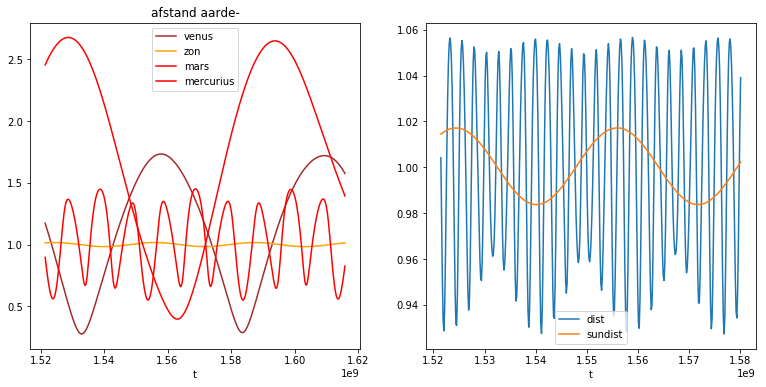

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

tf = time.time()
yr3 = list(rangef(tf, tf + 3*365.25*24*3600))

fig, ax = plt.subplots(1,2, figsize=(13,6))
obj_pos_df(ephem.Venus(), yr3).plot(x='t', y='dist', title="afstand aarde-", ax=ax[0],
                                    color='brown', label='venus')
sun = ephem.Sun()
obj_pos_df(sun, yr3).plot(x='t', y='dist', color='orange', ax=ax[0], label='zon')
obj_pos_df(ephem.Mars(), yr3).plot(x='t', y='dist', color='red', ax=ax[0], label='mars')
obj_pos_df(ephem.Mercury(), yr3).plot(x='t', y='dist', color='red', ax=ax[0], label='mercurius')

moon = ephem.Moon()
d140 = list(rangef(tf, tf + 2*340*24*3600))
moondist = obj_pos_df(moon, d140)
sundist = obj_pos_df(sun, d140)
moondist['sundist'] = sundist.dist/sundist.dist.mean()
moondist.dist = moondist.dist/moondist.dist.mean()

moondist.plot(x='t', y=['dist', 'sundist'], ax=ax[1])

In [4]:
moondist.dist.mean()

1.0

Hmm geeft geen BS meer.. Maar `a_ra` en `a_dec` zijn nog steeds niet de waarden die ik wil..

### Relatief tot aarde (maar nog niet gewenste coordinaatsysteem)

In [5]:
import math
from math import cos, sin

def angles_from_opposite_side(obj, date):
    o1, o2 = ephem.Observer(), ephem.Observer()
    o1.date, o1.lon, o1.lat, o1.pressure = date, 0, 0, 0
    o2.date, o2.lon, o2.lat, o2.pressure = date, '180', 0, 0

    obj.compute(o1)
    az1, alt1, d1 = obj.az, obj.alt, obj.earth_distance
    obj.compute(o2)
    az2, alt2, d2 = obj.az, obj.alt, obj.earth_distance
    return az1,az2, alt1,alt2, d1,d2

def altaz_rel_earth(obj, date):
    az1,az2, alt1,alt2, d1,d2 = angles_from_opposite_side(obj, date)
    return (az1 - az2)/2, (alt1 - alt2)/2, (d1+d2)/2

def rel_earth(obj, date):
    az, alt, d = altaz_rel_earth(obj, date)
    return (d*sin(alt), d*sin(az)*cos(alt), d*cos(az)*cos(alt))

Verwachten dat de evenaar de altitude `.alt` ongeveer(exclusief paralax) min op longitude=180 is,
dit lijkt te kloppen.

Verwachten dat de azimuth rond de 90 en 270 heen en weer gaat.. It lijkt niet te kloppen, het is alsof de
azimuth relative tot west, niet noord  zit.

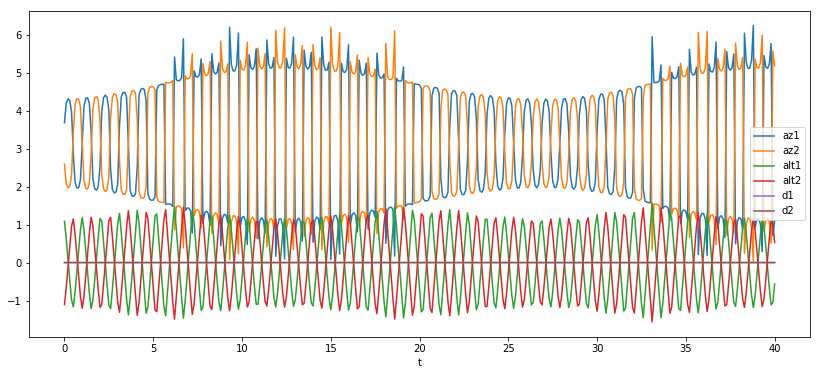

In [6]:
pd.DataFrame([(date, *angles_from_opposite_side(moon, date)) for date in rangef(0, 40*24*3600*ephem.second)],
             columns=('t', 'az1', 'az2', 'alt1', 'alt2', 'd1','d2')).plot(x='t', figsize=(14,6))

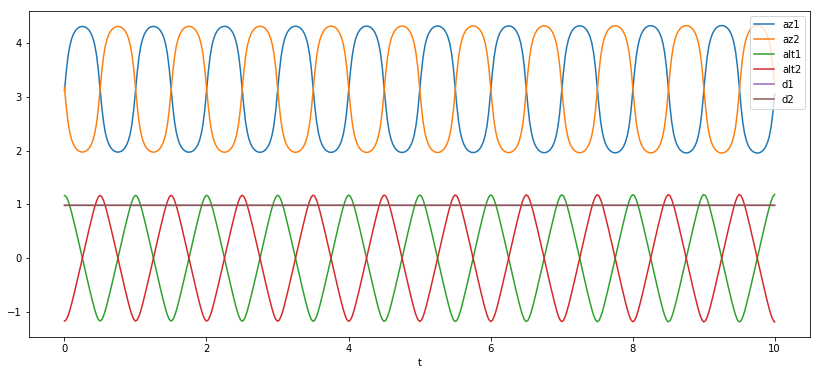

In [7]:
pd.DataFrame([(date, *angles_from_opposite_side(sun, date)) for date in rangef(0, 10*24*3600*ephem.second)],
             columns=('t', 'az1', 'az2', 'alt1', 'alt2', 'd1', 'd2')).plot(x='t', figsize=(14,6))

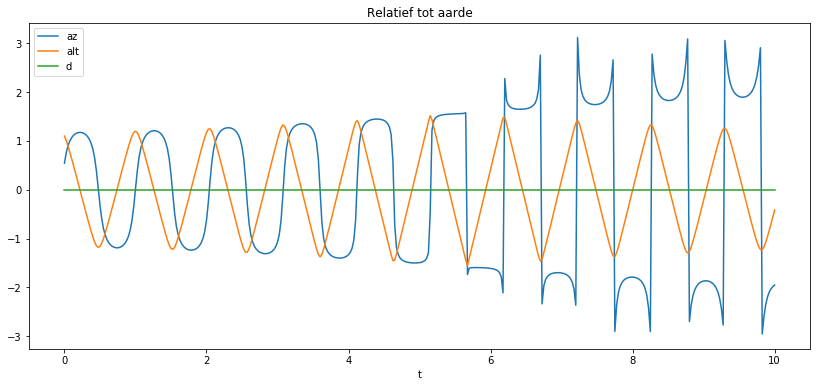

In [8]:
pd.DataFrame([(date, *altaz_rel_earth(moon, date)) for date in rangef(0, 10*24*3600*ephem.second)],
             columns=('t', 'az', 'alt', 'd')).plot(x='t', figsize=(14,6), title="Relatief tot aarde")

De relatieve positie, de x,y gaan ~ongeveer een cirkel omdat de aarde draait, en
de z(schuinheid, todo word) oscilleert met de dag.

De onderste plot snap ik niet als de tilt van de Aarde in dezelfde richting als de baan van de maan,
zou de z-variatie het minst moeten zijn en tegenovergestelt, het meeste.

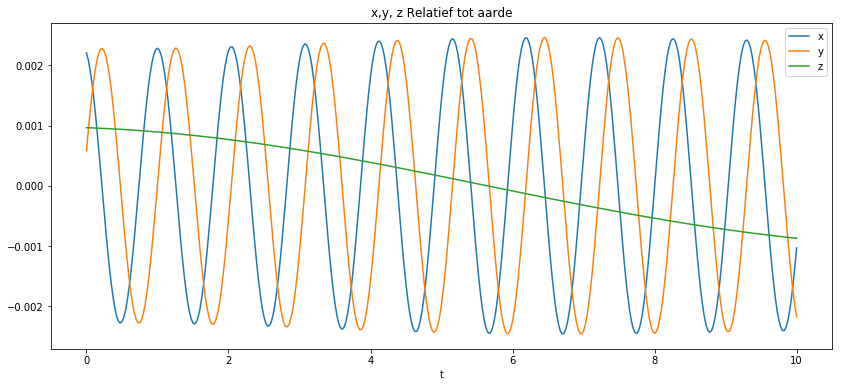

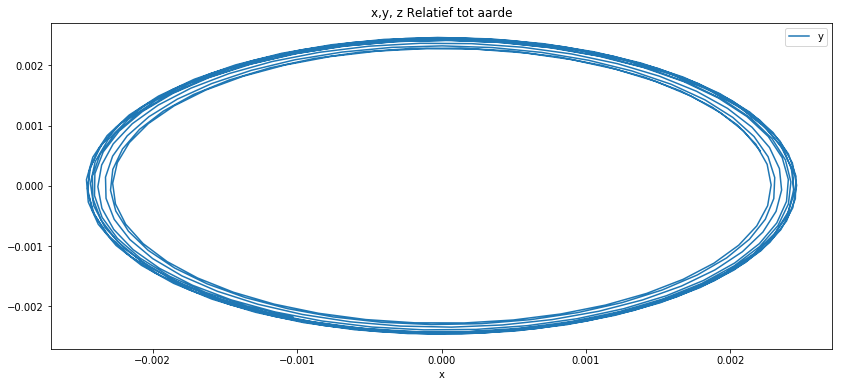

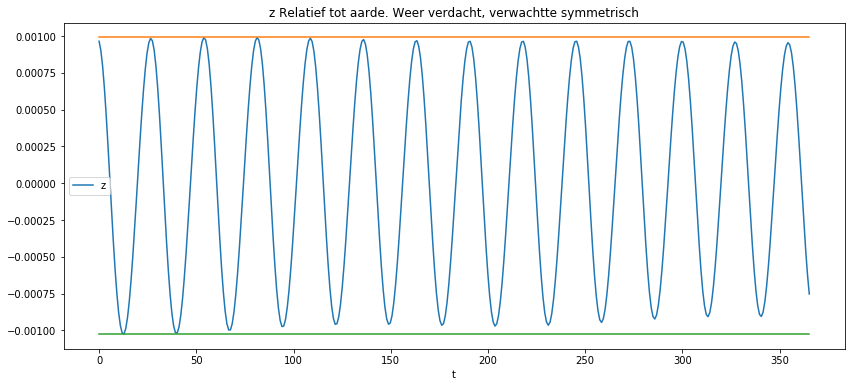

In [9]:
xyz_df_10d = pd.DataFrame([(date/ephem.second/3600/24, *rel_earth(moon, date)) for date in rangef(0, 10*24*3600*ephem.second)],
             columns=('t', 'x', 'y', 'z'))
xyz_df_10d.plot(x='t', figsize=(14,6), title="x,y, z Relatief tot aarde")
xyz_df_10d.plot(x='x', y='y', figsize=(14,6), title="x,y, z Relatief tot aarde")

year = list(rangef(0, 365.25*24*3600*ephem.second))
xyzdf = pd.DataFrame([(date, *rel_earth(moon, date)) for date in year], columns=('t', 'x', 'y', 'z'))

fig, ax = plt.subplots(figsize=(14,6))
xyzdf.plot(x='t',y='z', title="z Relatief tot aarde. Weer verdacht, verwachtte symmetrisch", ax=ax)

g={'max':xyzdf['z'].max(), 'min':xyzdf['z'].min()}
plt.plot(year, [g['max']]*len(year), axes=ax)
plt.plot(year, [g['min']]*len(year), axes=ax)

Klutsy plot .. would be handy to have an easy "running maximum/minimum".

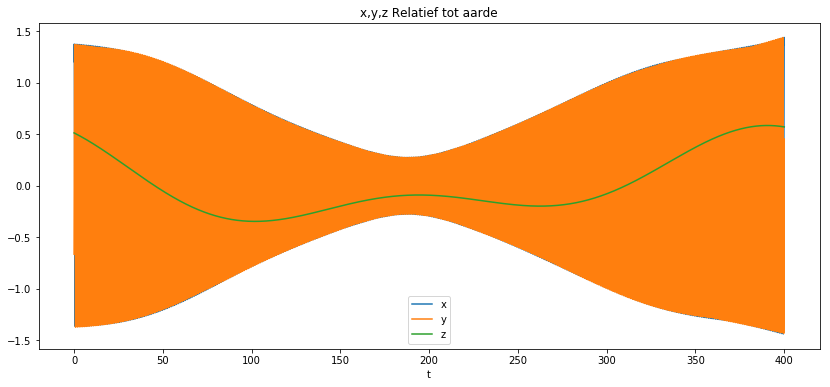

In [10]:
xyz_df_10d = pd.DataFrame([(date/ephem.second/3600/24, *rel_earth(ephem.Venus(), date))
                           for date in rangef(0, 400*24*3600*ephem.second, 10000)],
             columns=('t', 'x', 'y', 'z'))
xyz_df_10d.plot(x='t', figsize=(14,6), title="x,y,z Relatief tot aarde")

In [11]:
objs = { 'Earth':(None, 5.97237e24),
         'Moon':(ephem.Moon(), 7.342e22),
         'Venus':(ephem.Venus(), 4.8675e24),
         'Sun':(ephem.Sun(), 1.98855e30),
         'Mars':(ephem.Mars(), 6.4171e23),
         'Jupiter':(ephem.Jupiter(), 1.8982e27),
       }

import ephem
from earth_rel_pos import rel_earth

AU_m = 149597870700
G = 6.674e-11

# Actually only the sun and 
#relevant = [ephem.Moon(), ephem.Sun(), ephem.Venus(), ephem.Jupiter(), ephem.Mars()]
def gravity_gradient_o_m(obj,mass, t):
    rel = rel_earth(obj, t)
    rsqr = sum(x*x for x in rel)
    f = (-2*G*mass/rsqr**2) / AU_m**3 # (r^4 because the rel has r in there once.)
    return [f*x for x in rel]

def gravity_gradient(name, t):
    return gravity_gradient_o_m(*objs[name], t)

grad = gravity_gradient('Moon', 10)

## Zwaartekracht gradient
Absolute grootte daarom niet dagelijkse variatie, Duidelijk: Zon en maan zijn het
gros met een factor 10<sup>4</sup> op zijn best.

De maan zit op ongeveer een factor twee.

/home/jasper/.local/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


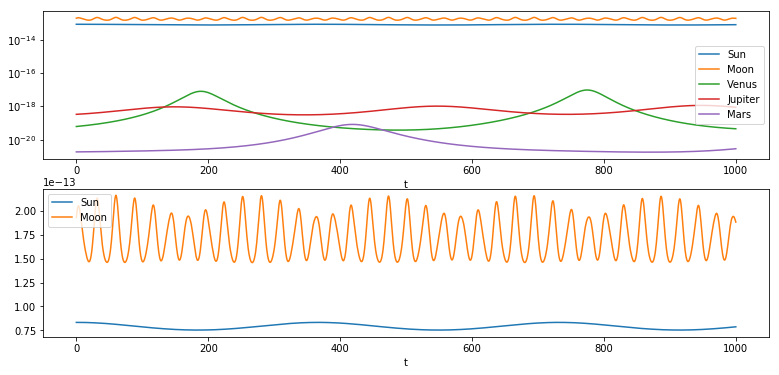

In [14]:
df = pd.DataFrame({ 't':list(rangef(0, 1000*24*3600*ephem.second, 10000))})
for name in ['Sun', 'Moon', 'Venus', 'Jupiter', 'Mars']:
    df[name] = [math.sqrt(sum(x*x for x in gravity_gradient(name, t))) for t in df.t]

fig, ax = plt.subplots(2,1, figsize=(13,6))
df.plot(x='t', ax=ax[0], logy=True)

df.plot(x=[df.t/ephem.second/3600/24], y=['Sun', 'Moon'], ax=ax[1])

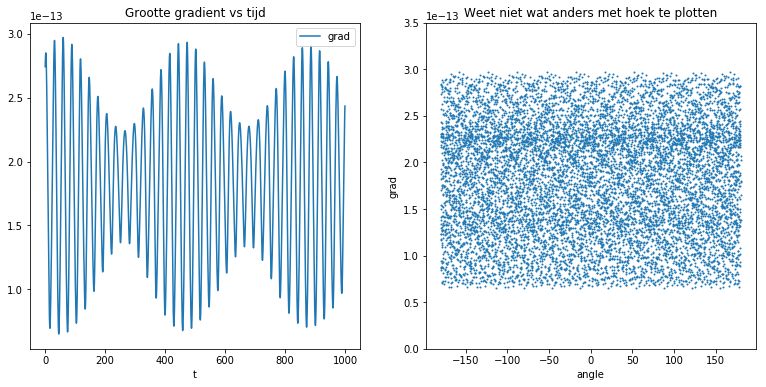

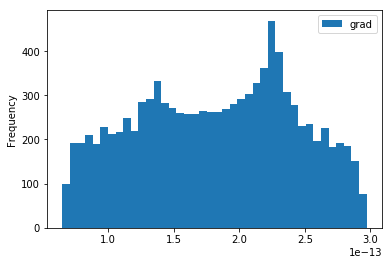

In [68]:
df = pd.DataFrame({ 't':list(rangef(0, 1000*24*3600*ephem.second, 10000))})

def gg(t):
    return (ca+cb for ca,cb in zip(gravity_gradient('Moon', t), gravity_gradient('Sun', t)))

df['grad'] = [math.sqrt(sum(c**2 for c in gg(t))) for t in df.t]
df['angle']  = [180*(math.atan2(*list(gg(t))[:2])/math.pi) for t in df.t]

fig, ax = plt.subplots(1,2, figsize=(13,6))
df.plot(x='t', y='grad', ax=ax[0], title="Grootte gradient vs tijd")
df.plot.scatter(x='angle', y='grad', ylim=(0, 3.5e-13), ax=ax[1], s=1,
                title="Weet niet wat anders met hoek te plotten")
df.plot.hist(y='grad', bins=40)

In [50]:
import datetime
ephem_start_t = datetime.datetime(1899, 12, 31, 12, 0).timestamp()

def unix_to_ephem(unix_t):
    return (unix_t - ephem_start_t)*ephem.second

Eens kijken of de dag en de hoek met de zon klopt. Lijkt erop.

In [65]:
ephem.Date(0).datetime()

datetime.datetime(1899, 12, 31, 12, 0)

In [60]:
import math
df = pd.DataFrame({'t':list(rangef(0, 2*24*3600*ephem.second))})
df['ah'] = [12*math.atan2(*rel_earth(sun, date)[:2]) for date in df.t]

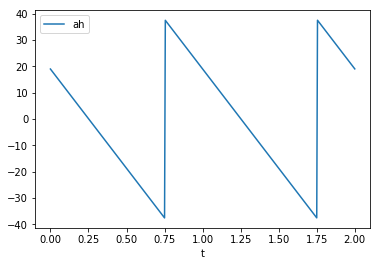

In [61]:
df.plot(x='t')